# Notebook 2: Defining the "Model Plant" & S-Curve CAPEX

Block 1: Setup & Parameters

We define our hypothetical 1100 MW plant and the cost/schedule scenarios derived from our Notebook 1 analysis.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 2: Defining the 'Model Plant' & S-Curve CAPEX ---")

# 1. Define Model Plant Parameters (The "Input Assumptions")
MODEL_CAPACITY_MW = 1100 # Typical AP1000 or APR1400 size

# Overnight Cost Scenarios ($/kW) - 2025 Dollars
# Note: "Overnight" means cost if built instantly (no interest)
COST_SCENARIOS = {
    'Low (China/Korea)': 4000,  # Efficient build
    'Med (France/UK)': 7000,    # Moderate delays/regs
    'High (US/Vogtle)': 11000   # First-of-a-kind issues
}

# Construction Duration Scenarios (Years)
# Based on our Notebook 1 analysis
DURATION_SCENARIOS = {
    'Brochure_Time': 5,   # The marketing pitch
    'Realistic_Time': 8,  # The global median
    'Disaster_Time': 12   # The tail risk
}

print(f"Model Plant Capacity: {MODEL_CAPACITY_MW} MW")
print(f"Cost Scenarios ($/kW): {COST_SCENARIOS}")
print(f"Duration Scenarios (Yrs): {DURATION_SCENARIOS}")

--- Notebook 2: Defining the 'Model Plant' & S-Curve CAPEX ---
Model Plant Capacity: 1100 MW
Cost Scenarios ($/kW): {'Low (China/Korea)': 4000, 'Med (France/UK)': 7000, 'High (US/Vogtle)': 11000}
Duration Scenarios (Yrs): {'Brochure_Time': 5, 'Realistic_Time': 8, 'Disaster_Time': 12}


Block 2: The S-Curve Function

This function generates the realistic "Bell Curve" of annual spending using a cumulative normal distribution.

Defining S-Curve CAPEX Function...


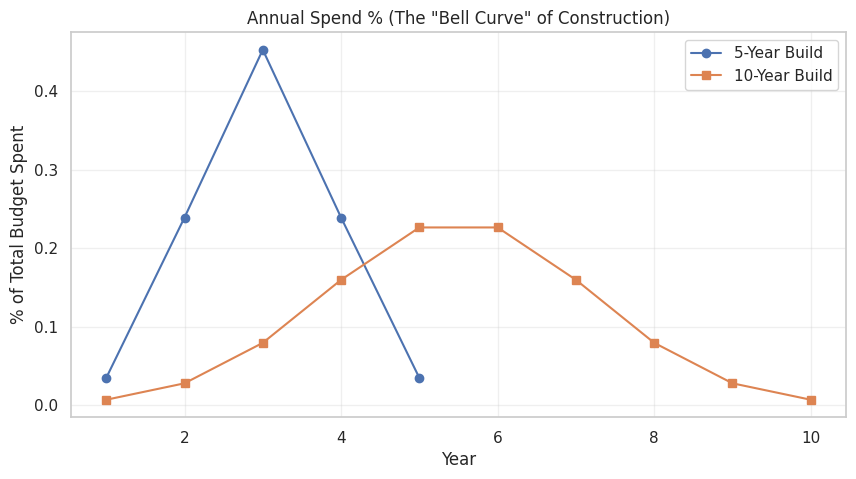

In [4]:
print("Defining S-Curve CAPEX Function...")

def get_s_curve_distribution(duration_years):
    """
    Returns the % of total CAPEX spent in each year based on a sigmoid S-curve.
    This mimics real construction: slow start (civil works), peak spend (MEP/Reactor), slow finish (testing).
    """
    # Create a time array (e.g., Year 1, 2, 3...)
    years = np.arange(1, duration_years + 1)

    # Calculate Sigmoid/Normal Distribution Curve
    # Centers the peak spend at 50% of duration
    x_norm = np.linspace(-3, 3, duration_years + 1)
    cdf = norm.cdf(x_norm)

    # Annual weights are the differences (marginal spend)
    annual_weights = np.diff(cdf)

    # Re-normalize strictly to 1.0 just in case of precision errors
    annual_weights = annual_weights / annual_weights.sum()

    return years, annual_weights

# Visualization Check: Compare 5-year vs 10-year profile
y5, w5 = get_s_curve_distribution(5)
y10, w10 = get_s_curve_distribution(10)

plt.figure(figsize=(10, 5))
plt.plot(y5, w5, marker='o', label='5-Year Build')
plt.plot(y10, w10, marker='s', label='10-Year Build')
plt.title('Annual Spend % (The "Bell Curve" of Construction)')
plt.xlabel('Year')
plt.ylabel('% of Total Budget Spent')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Block 3: Generating the Schedule

We apply the S-Curve logic to every scenario to build the master cash flow table.

In [5]:
print("Generating Master CAPEX Schedule (Cash Outflows)...")

schedule_rows = []

# Loop through every combination of Cost and Duration
for cost_label, cost_per_kw in COST_SCENARIOS.items():
    for dur_label, duration in DURATION_SCENARIOS.items():

        # 1. Calculate Total Overnight Cost (The Budget)
        total_capex_millions = (MODEL_CAPACITY_MW * 1000 * cost_per_kw) / 1e6

        # 2. Get the Annual Spending Weights
        years, weights = get_s_curve_distribution(duration)

        # 3. Calculate Annual Cash Outflows
        annual_spend = total_capex_millions * weights

        # 4. Store Data
        for y, spend_amt, weight in zip(years, annual_spend, weights):
            schedule_rows.append({
                'Scenario_Name': f"{cost_label} / {dur_label}",
                'Cost_Type': cost_label,
                'Duration_Type': dur_label,
                'Year_Index': y,
                'Total_Budget_M': total_capex_millions,
                'Annual_Spend_M': spend_amt,
                'Cumulative_Progress_%': weight # Storing marginal % for now
            })

df_capex = pd.DataFrame(schedule_rows)

# Calculate True Cumulative %
df_capex['Cumulative_Progress_%'] = df_capex.groupby('Scenario_Name')['Cumulative_Progress_%'].cumsum()

print(f"Generated {len(df_capex)} schedule records.")
print(df_capex[['Scenario_Name', 'Year_Index', 'Annual_Spend_M', 'Cumulative_Progress_%']].head(10))

Generating Master CAPEX Schedule (Cash Outflows)...
Generated 75 schedule records.
                        Scenario_Name  Year_Index  Annual_Spend_M  \
0   Low (China/Korea) / Brochure_Time           1      152.565749   
1   Low (China/Korea) / Brochure_Time           2     1051.459039   
2   Low (China/Korea) / Brochure_Time           3     1991.950424   
3   Low (China/Korea) / Brochure_Time           4     1051.459039   
4   Low (China/Korea) / Brochure_Time           5      152.565749   
5  Low (China/Korea) / Realistic_Time           1       47.977658   
6  Low (China/Korea) / Realistic_Time           2      240.814155   
7  Low (China/Korea) / Realistic_Time           3      705.112324   
8  Low (China/Korea) / Realistic_Time           4     1206.095862   
9  Low (China/Korea) / Realistic_Time           5     1206.095862   

   Cumulative_Progress_%  
0               0.034674  
1               0.273642  
2               0.726358  
3               0.965326  
4               1.0000

Block 4: Visualization & Export

We visualize the "S-Curve" and the annual cash burden.

Visualizing CAPEX Cash Flows...


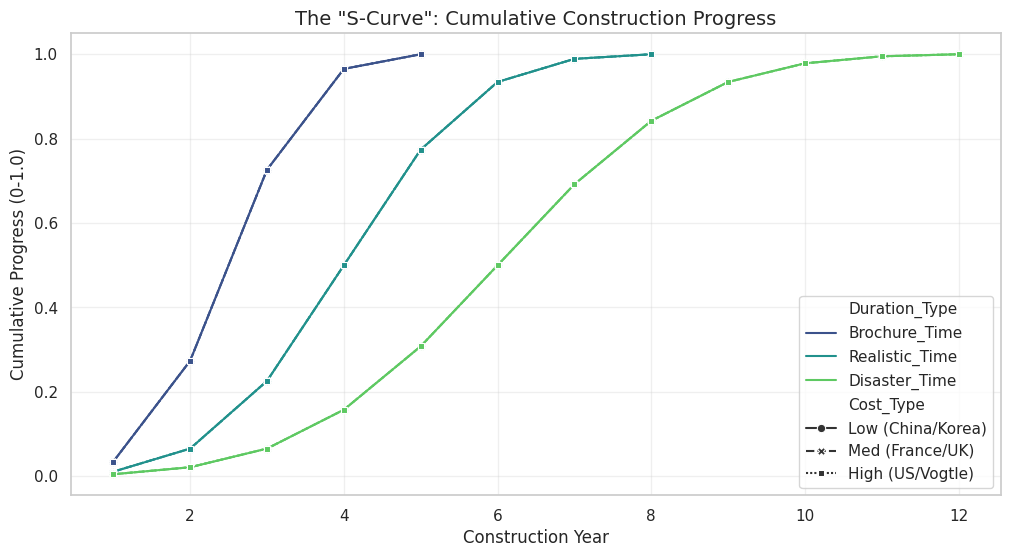

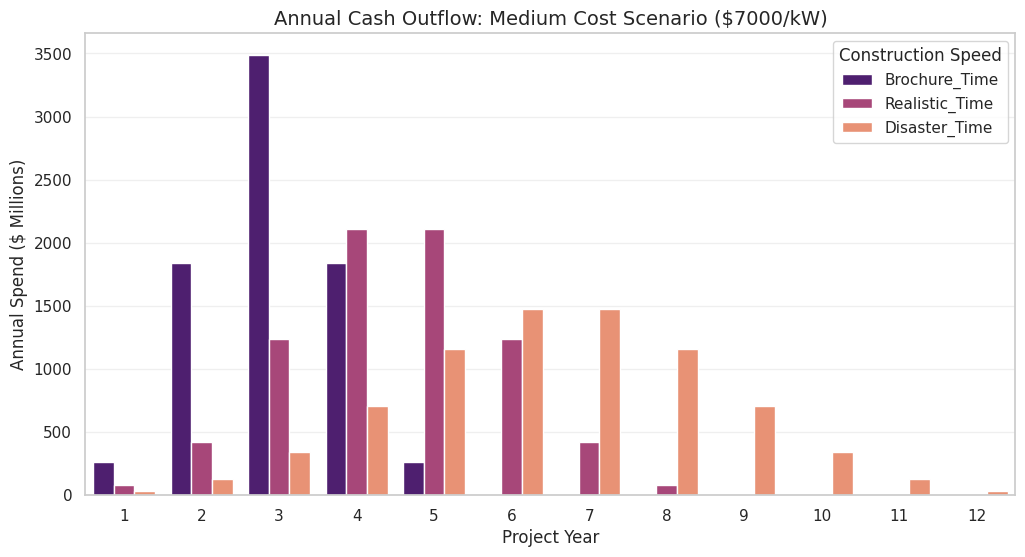

CAPEX Schedule saved to 'capex_schedule.csv'. Ready for Notebook 3.


In [6]:
print("Visualizing CAPEX Cash Flows...")

# 1. Plot Cumulative Spending (S-Curve)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_capex,
    x='Year_Index',
    y='Cumulative_Progress_%',
    hue='Duration_Type',
    style='Cost_Type',
    markers=True,
    palette='viridis'
)
plt.title('The "S-Curve": Cumulative Construction Progress', fontsize=14)
plt.ylabel('Cumulative Progress (0-1.0)')
plt.xlabel('Construction Year')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Plot Annual Cash Outflow (The Burden)
# Filter for just one Cost Scenario (e.g., Med) to see Duration impact clearly
df_plot_med = df_capex[df_capex['Cost_Type'] == 'Med (France/UK)']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_plot_med,
    x='Year_Index',
    y='Annual_Spend_M',
    hue='Duration_Type',
    palette='magma'
)
plt.title('Annual Cash Outflow: Medium Cost Scenario ($7000/kW)', fontsize=14)
plt.ylabel('Annual Spend ($ Millions)')
plt.xlabel('Project Year')
plt.legend(title='Construction Speed')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 3. Export
df_capex.to_csv('capex_schedule.csv', index=False)
print("CAPEX Schedule saved to 'capex_schedule.csv'. Ready for Notebook 3.")